# Insights Analyst Technical Test


Goal:
Find out which algorithm will performing better to provide the members with best experience.
(Roger the Re-ranker and Penny’s Personalisation)

Analysis flow:
1. Data pre-precossing
2. Data Visulisation 
3. AB Test Analysis


In [2]:
# import package
import numpy as np
import pandas as pd
import scipy 
from scipy import stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [3]:
# Import source data from csv file 
df = pd.read_csv('sql_input_201902.csv')
df.head(5)

,date_id,group_id,session_result,session_count
0,25/06/2018,A,0,763
1,25/06/2018,B,0,777
2,25/06/2018,A,1,3597
3,25/06/2018,B,1,3551
4,26/06/2018,A,0,694


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   date_id         40 non-null     object
 1   group_id        40 non-null     object
 2   session_result  40 non-null     int64 
 3   session_count   40 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 1.4+ KB


In [5]:
# Check interference data: 
# e.g. Overlap: same group member could be in the different groups, '0' value
df[["session_count"]].describe()  

,session_count
count,40.000000
mean,2201.300000
std,1272.318401
min,626.000000
25%,1170.500000
50%,1961.000000
75%,3223.500000
max,6510.000000


In [6]:
# Plot 1
# Data Aggregation, group the data by Date (date_id) and the group_id (A, B), Sum the session count
df_result = df.groupby(
    ['date_id','group_id'], as_index = False
    ).agg(
            {
                'session_count': sum    
            })

df_result

,date_id,group_id,session_count
0,01/07/2018,A,4553
1,01/07/2018,B,4475
2,02/07/2018,A,4293
3,02/07/2018,B,4092
4,03/07/2018,A,4310
5,03/07/2018,B,3797
6,04/07/2018,A,4067
7,04/07/2018,B,3922
8,25/06/2018,A,4360
9,25/06/2018,B,4328


In [7]:
# create a dataframe for visulisation
# Date, Session count, Group_id
d_A = df_result[df_result['group_id'] == "A"]
da = d_A[['date_id', 'session_count']]
da = da.rename(columns={'session_count':'Group_A'})
d_B = df_result[df_result['group_id'] == "B"]
db = d_B[['date_id', 'session_count']]
db = db.rename(columns={'session_count':'Group_B'})
df_session = pd.merge(da,db)

df_session

,date_id,Group_A,Group_B
0,01/07/2018,4553,4475
1,02/07/2018,4293,4092
2,03/07/2018,4310,3797
3,04/07/2018,4067,3922
4,25/06/2018,4360,4328
5,26/06/2018,4047,4383
6,27/06/2018,3479,4287
7,28/06/2018,3889,7280
8,29/06/2018,4751,4369
9,30/06/2018,4680,4690


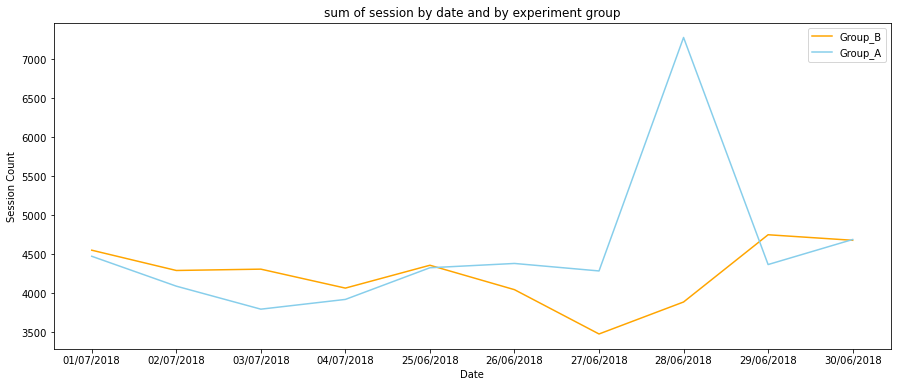

In [8]:
plt.figure(figsize=(15,6))
plt.title("sum of session by date and by experiment group")
plt.xlabel("Date")
plt.ylabel("Session Count")
plt.plot(df_session.date_id, df_session.Group_A,color="orange")
plt.plot(df_session.date_id, df_session.Group_B,color="skyblue")
plt.legend(['Group_B', 'Group_A'], loc = 1)


Finding: 
1. The conversion rate was much higher than others on 28 June 2018, 


28 June 2018 is a Thursday. As usual, there won't be such a big session count on Thursday, maybe there was a promotion on the website that day. However, due to the small amount of data, it's not capable of finding out the reason for this. 
If there is enough data, I will find the evidence that the session count and conversion rate are abnormal for this day and exclude the data.

2. From 26 June 2018 to 28 June 2018, the session count of group B were larger than group A. From 30 June 2018 to 04 July 2018 the session count of group B starts to exceed the session count of group A.

At the beginning of this experiment, I think at the beginning of the experiment, users in group B had not yet adapted to the new algorithm, but after a few days, the new algorithm gradually attracted more traffic. The performance of groups A and B will be analysed and proved in later steps.

In [56]:
# Plot 2
# Data Aggregation, group by group_id (A, B), Sum the session count
df_result = df.groupby(
    ['group_id'], as_index = False
    ).agg(
            {
                'session_count': sum
            })

df_result


,group_id,session_count
0,A,42429
1,B,45623


In [10]:
# function to add value labels
x = df_result['group_id']
y = df_result['session_count']
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

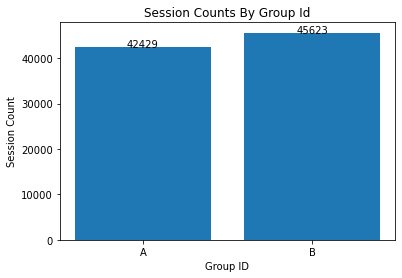

In [11]:
# plot bar chart
plt.bar(x, y)
addlabels(x, y) # calling the function to add value labels
plt.title('Session Counts By Group Id')
plt.xlabel('Group ID')
plt.ylabel('Session Count')
plt.show()

Finding:

This bar chart is used to check the sample size of each group. To make the AB Test results more reliable and accurately, during the experiment both the control group and treatment group should have a similar sample size. As we can see clearly from the bar chart, the session count of Group A (the control group) is 42429, meanwhile, the session count of Group B (the treatment group) is 45623, they are similar in number. 

If the session count difference is particularly large, I will select a similar number of datasets for future analysis.

In [12]:
# Plot 3

df_result = df.groupby(
    ['group_id', 'session_result'], as_index = False
    ).agg(
            {
                'session_count': sum,
            })


df_result

,group_id,session_result,session_count
0,A,0,11072
1,A,1,31357
2,B,0,10947
3,B,1,34676


In [49]:
# Plot 3, total conversion rate
df_cr = pd.DataFrame({'group_id': ['A', 'B'],
                   '0': [11072, 10947],
                   '1': [31357, 34676],
                   'Total': [42429, 45623],
                   'Rate': [0.739, 0.760]},
                   columns = ['group_id', '0', '1', 'Total', 'Rate'])
df_cr

,group_id,0,1,Total,Rate
0,A,11072,31357,42429,0.739
1,B,10947,34676,45623,0.760


In [50]:
# function to add value labels
x = df_cr['group_id']
y = df_cr['Rate']
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

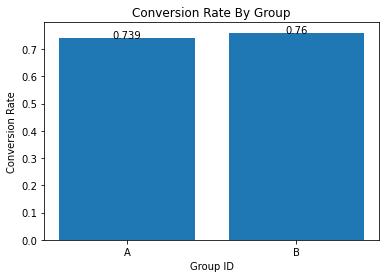

In [51]:
# plot bar chart
plt.bar(x, y)
addlabels(x, y) # calling the function to add value labels
plt.title('Conversion Rate By Group')
plt.xlabel('Group ID')
plt.ylabel('Conversion Rate')
plt.show()

Hypotheise:

H0： There is no significate different in conversion rate by Group A and Group B.
H1:  There is significate different in conversion rate by Group A and Group B.


Chi-Squard test


In [52]:
A_convert = df_cr.at[0, '1']
B_convert = df_cr.at[1, '1']
A_total = df_cr.at[0, 'Total']
B_total = df_cr.at[1, 'Total']
df_cr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   group_id  2 non-null      object 
 1   0         2 non-null      int64  
 2   1         2 non-null      int64  
 3   Total     2 non-null      int64  
 4   Rate      2 non-null      float64
dtypes: float64(1), int64(3), object(1)
memory usage: 208.0+ bytes


In [53]:
T = np.array([[A_convert, A_total], [B_convert, B_total]])

In [54]:
T

array([[31357, 42429],
       [34676, 45623]], dtype=int64)

Findings:

1. The total conversion rate between 30 June 2018 and 04 July 2018 of Group A and Group B are 73.9% and 76% respectively.
2. In this experiment, the conversion rate of Group B is larger than group A.

This can indicate that the algorithm used by group B was performed better than A. 

However, on 28 June 2018, Group B experienced an abnormally large amount of traffic, and the overall session count of Group B was 7% higher than that of Group A. All of these may lead to that the conversion rate of group B is higher than that of group A. Due to these two reasons, I cannot draw specific conclusions about which algorithm is better.

More dataset are required for the final conclusions.

In [26]:
# Plot 4
d_a0 = df[df['session_result'] == 0]
d_a0 = d_a0[d_a0['group_id'] == "A"]
d_a00 = d_a0[['date_id', 'session_count']]
d_a00 = d_a00.rename(columns={'session_count':'group_0'})

d_a1 = df[df['session_result'] == 1]
d_a1 = d_a1[d_a1['group_id'] == "A"]
d_a11 = d_a1[['date_id', 'session_count']]
d_a11 = d_a11.rename(columns={'session_count':'group_1'})

df_session_resultA = pd.merge(d_a00,d_a11)
df_session_resultA['total_session'] = df_session_resultA['group_0'] + df_session_resultA['group_1']
df_session_resultA['Conversion_rateA'] = df_session_resultA['group_1']/df_session_resultA['total_session']
df_session_resultA = df_session_resultA[['date_id', 'Conversion_rateA']]
df_session_resultA

,date_id,Conversion_rateA
0,25/06/2018,0.825000
1,26/06/2018,0.828515
2,27/06/2018,0.820063
3,28/06/2018,0.802520
4,29/06/2018,0.747632
5,30/06/2018,0.686752
6,01/07/2018,0.714254
7,02/07/2018,0.683904
8,03/07/2018,0.659397
9,04/07/2018,0.648389


In [22]:
d_b0 = df[df['session_result'] == 0]
d_b0 = d_b0[d_b0['group_id'] == "B"]
d_b00 = d_b0[['date_id', 'session_count']]
d_b00 = d_b00.rename(columns={'session_count':'group_0'})

d_b1 = df[df['session_result'] == 1]
d_b1 = d_b1[d_b1['group_id'] == "B"]
d_b11 = d_b1[['date_id', 'session_count']]
d_b11 = d_b11.rename(columns={'session_count':'group_1'})

df_session_resultB = pd.merge(d_b00,d_b11)
df_session_resultB['total_session'] = df_session_resultB['group_0'] + df_session_resultB['group_1']
df_session_resultB['Conversion_rateB'] = df_session_resultB['group_1']/df_session_resultB['total_session']
df_session_resultB = df_session_resultB[['date_id', 'Conversion_rateB']]
df_session_resultB

,date_id,Conversion_rateB
0,25/06/2018,0.820471
1,26/06/2018,0.801734
2,27/06/2018,0.805458
3,28/06/2018,0.894231
4,29/06/2018,0.747539
5,30/06/2018,0.693603
6,01/07/2018,0.686257
7,02/07/2018,0.708456
8,03/07/2018,0.713721
9,04/07/2018,0.624426


In [28]:
df_session_result_AB = pd.merge(df_session_resultA, df_session_resultB)
df_session_result_AB

,date_id,Conversion_rateA,Conversion_rateB
0,25/06/2018,0.825000,0.820471
1,26/06/2018,0.828515,0.801734
2,27/06/2018,0.820063,0.805458
3,28/06/2018,0.802520,0.894231
4,29/06/2018,0.747632,0.747539
5,30/06/2018,0.686752,0.693603
6,01/07/2018,0.714254,0.686257
7,02/07/2018,0.683904,0.708456
8,03/07/2018,0.659397,0.713721
9,04/07/2018,0.648389,0.624426


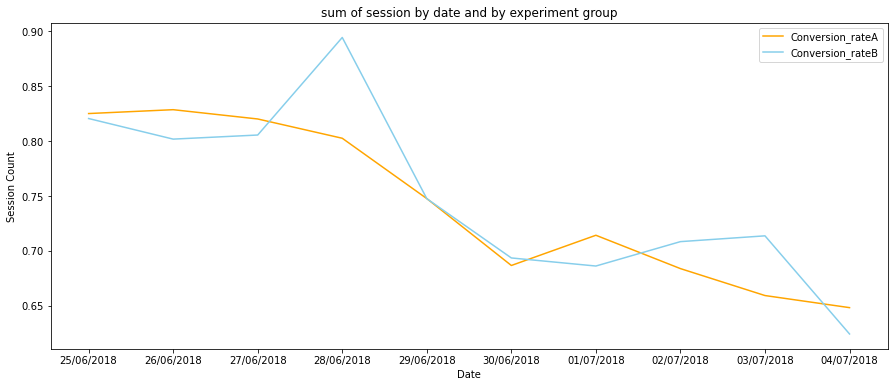

In [29]:
plt.figure(figsize=(15,6))
plt.title("sum of session by date and by experiment group")
plt.xlabel("Date")
plt.ylabel("Session Count")
plt.plot(df_session_result_AB.date_id, df_session_result_AB.Conversion_rateA,color="orange")
plt.plot(df_session_result_AB.date_id, df_session_result_AB.Conversion_rateB,color="skyblue")
plt.legend(['Conversion_rateA', 'Conversion_rateB'], loc = 1)

C:\Users\Lindsay\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Lindsay\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Conversion_rateB', ylabel='Density'>

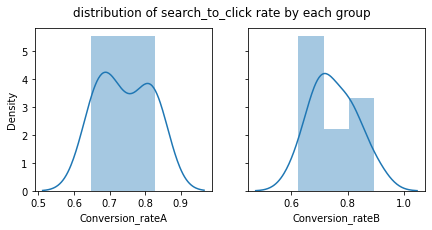

In [66]:
# Distribution
# Distribution of Conversion rate ()

# stc group A & B density/distribution  
f, axes = plt.subplots(1, 2, figsize=(7, 3), sharey=True)
f.suptitle('distribution of search_to_click rate by each group ')

# Group A 
sns.distplot(df_session_result_AB.Conversion_rateA, ax=axes[0])

# Group B
sns.distplot(df_session_result_AB.Conversion_rateB, ax=axes[1])


In [63]:
# Begin Test
# Chi-squared test
scipy.stats.chi2_contingency(T, correction=False, lambda_="log-likelihood")[:2]

(7.39777710821204, 0.006530452568427456)

In [64]:
# T- Test
import scipy.stats as stats
t_stat, p_val= stats.ttest_ind(df_session_result_AB.Conversion_rateA,df_session_result_AB.Conversion_rateB)
t_stat , p_val

# P value

(-0.23319523090997338, 0.8182410910496379)

Findings:
    
1. The trend of conversion rates for both group A and group B are going down from 25 June 2018 to 04 July 2018.
2. The conversion rate reached the peak on 28 June 2018
3. 25 June 2018 is a Monday